# This notebook is used to calculate the $\gamma + \gamma \rightarrow \pi^{0}$ matching efficiency & purity
### For the statistical uncertainties, the beta binomial distribution is used.

In [1]:
import sys
sys.path.append("../../lartpc_mlreco3d")
sys.path.append("../../pi0_reco")

In [2]:
import yaml
chain_cfg = '''
name: pi0_chain_test     # Name of the chain to name the output files
verbose: false           # true, false
analyse: true            # true, false
mlreco: 
  cfg_path: ../../config_files/network_configs/pi0_full_pid_v02_20210322.cfg      # IO and/or network configuration
  model_path: ../../weights/weights_francois/full_pid_v02/snapshot-48499.ckpt    # 11499
  batch_size: 1          # Number of event to process at each iteration
  data_keys:             # Test file
  #- ../../data/pi0/pi0_dunend_v1_p00.root
  - ../../data/pi0/pi0_dunend_v2_p00.root
modules:
  segment: 
    method: uresnet      # label, uresnet
  deghost:
    method: none         # label, uresnet, none
  charge2e:
    method: none         # label, constant, average, none
    cst: 0.0082          # energy response constant (0.0082 for mask, 0.0052 for uresnet)
    average: 0.877       # energy response average (1.3693 for mask, 0.877 for uresnet)
  shower_fragment:  
    method: gnn          # label, dbscan, gnn
    eps: 1.999
    min_samples: 1
  shower_primary:
    method: gnn          # label, gnn
  shower_start:     
    method: ppn          # label, ppn, curv
  shower_direction: 
    method: geo          # label, geo
    mode: cent
    metric: path
    min_distance: 0
    max_distance: 5
    optimize: true
    normalize: true
    weighted: false
  shower_cluster:
    method: gnn          # label, cone, gnn
    predict_mode: score
    scale_embedding: 1.0
    IP: 15
    Distance: 300
  shower_energy: 
    method: pixel_sum    # label, pixel_sum
    fudge: 1.205
  shower_id:
    method: edep         # label, edep, vertex, gnn
  shower_match:
    method: angle        # label, angle, gnn
    min_energy: 10
    max_angle: 20
    select_photons: false
    apply_fiducial: false
    match_to_ppn: true
    match_to_track: true
    refit_dir: true      # true, false
    redit_cone: false    # true, false
  fiducial:
    method: edge_dist         # none, edge_dist
    max_distance: 5
    lower_bound: 0
    upper_bound: 768
'''

#chain_cfg = yaml.safe_load(chain_cfg)

# Reading network config from file:
#with open ('/sdf/home/r/rberner/reconstruction/config_files/network_configs/fullChain_grappa_20210312.cfg','r') as config_file:
#    chain_cfg = config_file.read()#.replace(',','\n')
#print(chain_cfg)

print('Done.')

Done.


In [3]:
# Progress bar
from IPython.display import HTML, display
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [4]:
class Results(object):
    '''
    Class for the storage of result acquired during chain.run_loop() process.
    The attributes are added in a dynamic way.
    This class can be used as:
    res = Results()
    res.attribute = someobject
    Use Results.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    See below...
    '''
    
    pass

In [5]:
# Some imports
import numpy as np
from larcv import larcv
from numpy import linalg

Welcome to JupyROOT 6.22/02


In [6]:
# Reload the chain/logger each time during development
from importlib import reload
import pi0.chain
reload(pi0.chain)
import pi0.utils.logger
reload(pi0.utils.logger)

# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(chain_cfg)

Will store true shower information at: pi0_chain_test_shower_label_data.csv
Will store reconstructed shower information at: pi0_chain_test_shower_pred_data.csv

Config processed at: Linux volt003 3.10.0-1127.13.1.el7.x86_64 #1 SMP Tue Jun 23 15:46:38 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': [   '../../data/pi0/pi0_dunend_v2_p00.root'],
                                 'limit_num_files': 10,
                                 'name': 'LArCVDataset',
                                 'schema': {   'cluster_label': [   'parse_cluster3d_clean_full',
                                                                    'cluster3d_pcluster',
                                                                    'particle_pcluster',
                                                                    'sparse3d_pcluster_semantics'],
               

In [7]:
'''
# Define a list with the results obtained by run_loop()
ResultsList = []

# Loop over dataset
data_size  = 50 #len(chain.hs.data_io)

out = display(progress(0,data_size,'images'),display_id=True)
for event in range(data_size):
    chain.run_loop()
    
    print(' event ID:   ', chain.true_info['ev_id'])
    #print(chain)
    #print(chain._output.keys())
    print(' true n pi0: ', chain.true_info['n_pi0'])
    print(' reco n pi0: ', chain.reco_info['n_pi0'])
    print(' ------------- ')
    
    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))
'''
print('Done.')

Done.


In [8]:
# Define a list with the results obtained by run_loop()
ResultsList = []


data_size  = 1000 #len(chain.hs.data_io)

# Progress bar
out = display(progress(0,data_size,'images'),display_id=True)

# Loop over dataset
'''
# Filter to only the events to draw
filtered_eventIDs = [3,4,5,7,10]
chain.apply_event_filter(filtered_eventIDs)
for i in range(len(filtered_eventIDs)):
    chain.run_loop()
    chain.draw()
'''

for event in range(data_size):
    chain.run_loop()
    
    # Event selection:
    # ----------------
    skip_event = False
    skip_event_list = []
    # Continue if no true pi0 is in the event
    if chain.true_info['n_pi0'] == 0:
        #print(' === FAIL: n_pi0     =', chain.true_info['n_pi0'])
        skip_event = True
        skip_event_list.append(0)
        #out.update(progress(event,data_size,'images'))
        #continue
    
    # Select events with exactly 1 true pi0 -> gamma+gamma
    if chain.true_info['n_gammas'] != 2:
        #print(' === FAIL: n_gammas  =', chain.true_info['n_gammas'])
        skip_event = True
        skip_event_list.append(1)
        #out.update(progress(event,data_size,'images'))
        #continue
    #if len(chain.output['showers']) != 2:
    #    out.update(progress(event,data_size,'images'))
    #    skip_event = True
    #    continue
    
    # Select events where each photon of a pi0 decay has at least 20 MeV energy deposition
    for true_gamma_0 in range(chain.true_info['n_pi0']):
        if 2*chain.true_info['n_pi0'] != chain.true_info['n_gammas']:
            print('WARNING: true n_pi0s =', chain.true_info['n_pi0'], 'does not correspond to true n_gammas =', chain.true_info['n_gammas'])
        else:
            if chain.true_info['gamma_edep'][2*true_gamma_0]<20. or chain.true_info['gamma_edep'][2*true_gamma_0+1]<20.:
                skip_event = True
                skip_event_list.append(2)
    
    # Continue if true gamma ekin/edep < 0.8:
    for true_gamma_0 in range(chain.true_info['n_pi0']):
        if 2*chain.true_info['n_pi0'] != chain.true_info['n_gammas']:
            print('WARNING: true n_pi0s =', chain.true_info['n_pi0'], 'does not correspond to true n_gammas =', chain.true_info['n_gammas'])
        else:
            if chain.true_info['gamma_edep'][2*true_gamma_0] > 0. and chain.true_info['gamma_edep'][2*true_gamma_0+1] > 0.:
                if chain.true_info['gamma_ekin'][2*true_gamma_0]/chain.true_info['gamma_edep'][2*true_gamma_0] < 0.8 or\
                   chain.true_info['gamma_ekin'][2*true_gamma_0+1]/chain.true_info['gamma_edep'][2*true_gamma_0+1] < 0.8:
                    #print(' === FAIL: true ekin/edep =', chain.true_info['gamma_ekin']/chain.true_info['gamma_edep'], '< 0.8')
                    skip_event = True
                    skip_event_list.append(3)
                    #out.update(progress(event,data_size,'images'))
                    #continue
    
    # Continue if >= 1 true gamma is OOFV:
    #if len(chain.true_info['OOFV'])>0:
        #print(' === FAIL: true OOFV =', chain.true_info['OOFV'])
        #skip_event = True
        #skip_event_list.append(4)
        #out.update(progress(event,data_size,'images'))
        #continue
    
    if skip_event:
        out.update(progress(event,data_size,'images'))
        skip_event = False
        print(' Skip event', chain.true_info['ev_id'], '(failed selection cuts:', skip_event_list, ')')
        continue
    
    # Extract results:
    # ----------------
    # Instantiate Results class
    extracted_data = Results()
    
    # Add members of the Results class
    extracted_data.event_id                    = chain.true_info['ev_id']

    extracted_data.primaries_pdg_code          = chain.true_info['primaries_pdg_code']
    extracted_data.primaries_einit             = chain.true_info['primaries_einit']
    extracted_data.primaries_mom               = chain.true_info['primaries_mom']
    
    extracted_data.true_n_pi0s                 = chain.true_info['n_pi0']
    extracted_data.true_n_gammas               = chain.true_info['n_gammas']
    extracted_data.true_pi0_track_ids          = chain.true_info['pi0_track_ids']
    extracted_data.true_gamma_group_ids        = chain.true_info['gamma_group_ids']
    extracted_data.true_shower_particle_ids    = chain.true_info['shower_particle_ids']
    extracted_data.true_gamma_ids_making_compton_scat = chain.true_info['gamma_ids_making_compton_scat']
    extracted_data.true_pi0_ekin               = chain.true_info['pi0_ekin']
    extracted_data.true_gamma_pos              = chain.true_info['gamma_pos']
    extracted_data.true_gamma_dir              = chain.true_info['gamma_dir']
    extracted_data.true_gamma_mom              = chain.true_info['gamma_mom']
    extracted_data.true_gamma_ekin             = chain.true_info['gamma_ekin']
    extracted_data.true_gamma_edep             = chain.true_info['gamma_edep']
    extracted_data.true_gamma_voxels           = chain.true_info['gamma_voxels']
    extracted_data.true_gamma_n_voxels         = chain.true_info['gamma_n_voxels']
    extracted_data.true_gamma_first_step       = chain.true_info['gamma_first_step']
    extracted_data.compton_electron_first_step = chain.true_info['compton_electron_first_step']
    extracted_data.true_shower_first_edep      = chain.true_info['shower_first_edep']
    extracted_data.true_OOFV                   = chain.true_info['OOFV']
    extracted_data.true_gamma_angle            = chain.true_info['gamma_angle'] # [rad]
    extracted_data.true_pi0_mass               = chain.true_info['pi0_mass']
    
    extracted_data.reco_n_pi0s                 = chain.reco_info['n_pi0']
    extracted_data.reco_n_gammas               = chain.reco_info['n_gammas']
    extracted_data.reco_matches                = chain.reco_info['matches']
    extracted_data.reco_gamma_mom              = chain.reco_info['gamma_mom']
    extracted_data.reco_gamma_dir              = chain.reco_info['gamma_dir']
    extracted_data.reco_gamma_start            = chain.reco_info['gamma_start']
    extracted_data.reco_gamma_edep             = chain.reco_info['gamma_edep']
    extracted_data.reco_gamma_pid              = chain.reco_info['gamma_pid']
    extracted_data.reco_gamma_voxels_mask      = chain.reco_info['gamma_voxels_mask']
    extracted_data.reco_gamma_n_voxels_mask    = chain.reco_info['gamma_n_voxels_mask']
    extracted_data.reco_gamma_voxels           = chain.reco_info['gamma_voxels']
    extracted_data.reco_gamma_n_voxels         = chain.reco_info['gamma_n_voxels']
    extracted_data.reco_OOFV                   = chain.reco_info['OOFV']
    extracted_data.reco_gamma_angle            = chain.reco_info['gamma_angle'] # [rad]
    extracted_data.reco_pi0_mass               = chain.reco_info['pi0_mass']
    
    #for sh in range(extracted_data.true_n_gammas):
        #print(' true start: ', extracted_data.true_gamma_first_step[sh])
        #print(' true dir: ', extracted_data.true_gamma_dir[sh])
        #print(' ------------------------------------------------ ')

    extracted_data.clusters_n_clusters = len(chain.output['showers'])
    extracted_data.clusters_start      = []
    extracted_data.clusters_dir        = []
    extracted_data.clusters_voxels     = []
    extracted_data.clusters_energy     = []
    for i, shower in enumerate(chain.output['showers']):
        extracted_data.clusters_start.append(shower.start)
        extracted_data.clusters_dir.append(shower.direction)
        extracted_data.clusters_voxels.append(shower.voxels)
        extracted_data.clusters_energy.append(shower.energy)


    # Append the extracted data to the ResultsList
    ResultsList.append(extracted_data)
    
    
    # Print to screen
    # ----------------
    print_information = False #(extracted_data.true_n_pi0s+extracted_data.true_n_pi0s)>0 #True #(len(extracted_data.reco_pi0_mass)>0)
    if print_information: # and (extracted_data.true_n_pi0s>0 or extracted_data.reco_n_pi0s>0):
        print(' event_id:                    ', extracted_data.event_id)
        print(' primaries PDG:               ', extracted_data.primaries_pdg_code)
        print(' primaries einit:             ', extracted_data.primaries_einit)
        print(' primaries mom:               ', extracted_data.primaries_mom)
        print(' true_n_pi0s:                 ', extracted_data.true_n_pi0s)
        print(' reco_n_pi0s:                 ', extracted_data.reco_n_pi0s)
        print(' true_n_gammas:               ', extracted_data.true_n_gammas)
        print(' reco_n_gammas:               ', extracted_data.reco_n_gammas)
        #print(' clusters_n_clusters:         ', extracted_data.clusters_n_clusters)
        #print(' true_pi0_track_ids:          ', extracted_data.true_pi0_track_ids)
        #print(' true_gamma_group_ids:        ', extracted_data.true_gamma_group_ids)
        #print(' true_shower_particle_ids:    ', extracted_data.true_shower_particle_ids)
        #print(' true_gamma_ids_making_compt: ', extracted_data.true_gamma_ids_making_compton_scat)
        print(' true_pi0_ekin:               ', extracted_data.true_pi0_ekin)
        print(' true pi0 vertex:             ', extracted_data.true_gamma_pos)
        print(' true_gamma_pos:              ', extracted_data.true_gamma_pos)
        print(' true_gamma_dir:              ', extracted_data.true_gamma_dir)
        print(' reco_gamma_dir:              ', extracted_data.reco_gamma_dir)
        #print(' clusters_dir:                ', extracted_data.clusters_dir)
        print(' true_gamma_mom:              ', extracted_data.true_gamma_mom)
        print(' reco_gamma_mom:              ', extracted_data.reco_gamma_mom)
        print(' true_gamma_ekin:             ', extracted_data.true_gamma_ekin)
        print(' true_gamma_edep:             ', extracted_data.true_gamma_edep)
        print(' reco_gamma_edep:             ', extracted_data.reco_gamma_edep)
        #print(' true_gamma_voxels:           ', extracted_data.true_gamma_voxels)
        print(' true_gamma_n_voxels:         ', extracted_data.true_gamma_n_voxels)
        print(' reco_gamma_n_voxels:         ', extracted_data.reco_gamma_n_voxels)
        print(' true_OOFV:                   ', extracted_data.true_OOFV)
        print(' reco_OOFV:                   ', extracted_data.reco_OOFV)
        print(' true_gamma_first_step:       ', extracted_data.true_gamma_first_step)
        print(' compton_electron_first_step: ', extracted_data.compton_electron_first_step)
        print(' true_shower_first_edep:      ', extracted_data.true_shower_first_edep)
        print(' reco_gamma_start:            ', extracted_data.reco_gamma_start)
        #print(' clusters_start:              ', extracted_data.clusters_start)
        #print(' cluster_start: ')
        #for index in range(extracted_data.clusters_n_clusters):
        #    print('                  ', extracted_data.clusters_start[index])
        print(' matches:                     ', extracted_data.reco_matches)
        print(' true_gamma_angle [rad]:      ', extracted_data.true_gamma_angle)
        print(' reco_gamma_angle [rad]:      ', extracted_data.reco_gamma_angle)
        print(' true_pi0_mass:               ', extracted_data.true_pi0_mass)
        print(' reco_pi0_mass:               ', extracted_data.reco_pi0_mass)
        print(' ------------------------------------------------------ ')
    
    #print(' === Event', extracted_data.event_id, 'passed selection. N true/reco pi0:', extracted_data.true_n_pi0s, '/', extracted_data.reco_n_pi0s)
    #print(' === Primaries PDG: ', extracted_data.primaries_pdg_code)
    
    
    ##for clust in range(extracted_data.clusters_n_clusters):
    ##    print(' clust: ', clust)
    ##    print(len(chain.output['forward']['points'][0][clust][:]))
    
    
    # Draw event:
    # ----------------
    # Draw the last event if requested
    #i_draw    = 0
    #n_draw    = 5
    #if 'matches' in chain.output and len(chain.output['matches']): # and i_draw < n_draw:
    #    chain.draw()
    #    i_draw += 1

    #draw_eventIDs = [] #[2,4,5,6] #[8,14,15,16] #[1,4,5,7,8,53,54,68,70,71,73,76,78,79,80,83,84]
    #if chain.true_info['ev_id'] in draw_eventIDs:
    #    chain.draw()
    
    #if chain.true_info['n_gammas']==2 and chain.reco_info['n_gammas']==2:
    #    chain.draw()

    #if chain.reco_info['n_pi0']>0:
    #    chain.draw()
    
    #if chain.reco_info['n_pi0']>0:
    #    chain.draw()
    
    #if chain.true_info['n_pi0'] != chain.reco_info['n_pi0']:
    #    chain.draw()
    
    #chain.draw()
    
    #if print_information:
    #    print(' ------------------------------------------------------------------------------------------- ')

    # Update progress bar

    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))

print('Done.')

Segmentation Accuracy: 0.9782
PPN Accuracy: 0.9238
Shower fragment clustering accuracy: 0.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 0 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9771
PPN Accuracy: 0.8912
Shower fragment clustering accuracy: 0.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 1 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9721
PPN Accuracy: 0.9726
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 2 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9759
PPN Accuracy: 0.8603
Shower fragment clustering accuracy: 0.9091
Shower primary prediction accuracy: 1.0000
Track fragment clustering accuracy: 1.0000
Segmentation Accuracy: 0.9836
PPN Accuracy: 0.9286
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 1.00

../../pi0_reco/pi0/directions/estimator.py:115: RuntimeWarning:

invalid value encountered in true_divide



 Skip event 406 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9403
PPN Accuracy: 0.8062
Shower fragment clustering accuracy: 0.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 407 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9778
PPN Accuracy: 0.9027
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 1.0000
Track fragment clustering accuracy: 1.0000
Segmentation Accuracy: 0.9739
PPN Accuracy: 0.8198
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 1.0000
Track fragment clustering accuracy: 1.0000
Segmentation Accuracy: 0.9696
PPN Accuracy: 0.8184
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 410 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9826
PPN Accuracy: 0.9173
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy

../../pi0_reco/pi0/directions/estimator.py:115: RuntimeWarning:

invalid value encountered in true_divide



 Skip event 593 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9663
PPN Accuracy: 0.8744
Shower fragment clustering accuracy: 0.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 594 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9872
PPN Accuracy: 0.9793
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 0.9643
Segmentation Accuracy: 0.9774
PPN Accuracy: 0.8993
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy: 0.0000
Track fragment clustering accuracy: 1.0000
 Skip event 596 (failed selection cuts: [0, 1] )
Segmentation Accuracy: 0.9612
PPN Accuracy: 0.9015
Shower fragment clustering accuracy: 0.9697
Shower primary prediction accuracy: 1.0000
Track fragment clustering accuracy: 1.0000
Segmentation Accuracy: 0.9762
PPN Accuracy: 0.7863
Shower fragment clustering accuracy: 1.0000
Shower primary prediction accuracy

# Efficiency and Purity
### Note: Classify photon as properly matched if their
- reconstructed start position is closer than "spatial_tolerance" (a few px) from the true shower's start (= true photon's first step) and
- reconstructed direction is in agreement (up to "angular_tolerance") with the true shower's direction
- TODO: Could also consider voxel overlap between reco shower and true shower

In [9]:
class matching_eff_pur(object):
    '''
    Class for the storage of pi0 matching efficiency and purity
    '''
    # Defined attributes
    # -------------------------------------
    '''
    event_id
    true_n_pi0s
    reco_n_pi0s
    true_gamma_edep
    reco_gamma_edep
    true_pi0_ekin
    true_gamma_mom
    correctly_matched_pi0_ids
    wrongly_matched_pi0_ids
    correctly_matched_n_pi0
    wrongly_matched_pi0_ids
    correctly_matched_pi0_ids
    '''
    
    pass

In [10]:
eff_pur_list = []
print_info   = False

# Progress bar
out = display(progress(0,len(ResultsList),'images'),display_id=True)

for event, res in enumerate(ResultsList):
    
    if print_info: #res.event_id == 398: #print_info:
        print(' ================================================================ ')
        print(' event:               ', i)
        print(' event ID:            ', res.event_id)
        print(' true n pi0:          ', res.true_n_pi0s)
        print(' reco n pi0:          ', res.reco_n_pi0s)
        print(' true n gammas:       ', res.true_n_gammas)
        print(' reco n gammas:       ', res.reco_n_gammas)
        print(' true pi0 ekin:       ', res.true_pi0_ekin)
        print(' true gamma pos:      ', res.true_gamma_pos)
        print(' true gamma 1st step: ', res.true_gamma_first_step)
        print(' true gamma 1st edep: ', res.true_shower_first_edep)
        print(' reco gamma start:    ', res.reco_gamma_start)
        print(' true gamma dir:      ', res.true_gamma_dir)
        print(' reco gamma dir:      ', res.reco_gamma_dir)
        print(' true gamma mom:      ', res.true_gamma_mom)
        print(' reco gamma mom:      ', res.reco_gamma_mom)
        print(' true gamma ekin:     ', res.true_gamma_ekin)
        print(' true gamma edep:     ', res.true_gamma_edep)
        print(' reco gamma edep:     ', res.reco_gamma_edep)
        #print(' true_gamma_voxels mask:   ', res.true_gamma_voxels_mask)
        #print(' reco gamma voxels mask:   ', res.reco_gamma_voxels_mask)
        #print(' true_gamma n voxels mask: ', res.true_gamma_n_voxels_mask)
        #print(' reco gamma n voxels mask: ', res.reco_gamma_n_voxels_mask)
        #print(' true_gamma_voxels:        ', res.true_gamma_voxels)
        #print(' reco gamma voxels:        ', res.reco_gamma_voxels)
        #print(' reco gamma pid:           ', res.reco_gamma_pid)
        print(' true gamma n voxels: ', res.true_gamma_n_voxels)
        print(' reco gamma n voxels: ', res.reco_gamma_n_voxels)
        print(' true OOFV:           ', res.true_OOFV)
        print(' reco OOFV:           ', res.reco_OOFV)
        print(' true gamma angle:    ', res.true_gamma_angle)
        print(' reco gamma angle:    ', res.reco_gamma_angle)
        print(' true pi0 mass:       ', res.true_pi0_mass)
        print(' reco pi0 mass:       ', res.reco_pi0_mass)
        print(' reco matches:        ', res.reco_matches)

        #print(' clusters n clusters: ', res.clusters_n_clusters)
        print(' clusters start:      ', res.clusters_start)
        print(' clusters dir:        ', res.clusters_dir)
        #print(' clusters voxels:     ', res.clusters_voxels)
        print(' clusters energy:     ', res.clusters_energy)
    
    
    # Instantiate matching_eff_pur class
    eff_pur_data = matching_eff_pur()
    
    eff_pur_data.event_id                  = res.event_id
    eff_pur_data.true_n_pi0s               = res.true_n_pi0s
    eff_pur_data.reco_n_pi0s               = res.reco_n_pi0s
    eff_pur_data.true_gamma_edep           = res.true_gamma_edep
    eff_pur_data.reco_gamma_edep           = res.reco_gamma_edep
    eff_pur_data.reco_pi0_mass             = [res.reco_pi0_mass[2*i-1] for i in range(res.reco_n_pi0s)]
    eff_pur_data.correctly_matched_pi0_ids = []
    eff_pur_data.wrongly_matched_pi0_ids   = []
    eff_pur_data.true_pi0_ekin             = []
    eff_pur_data.true_gamma_mom            = []
    for k in range(res.true_n_pi0s):
        eff_pur_data.true_pi0_ekin.append(res.true_pi0_ekin[k])
        eff_pur_data.true_gamma_mom.append(res.true_gamma_mom[2*k])
        eff_pur_data.true_gamma_mom.append(res.true_gamma_mom[2*k+1])

    # Define the tolerances for a reco shower to be accepted as properly matched to a true shower
    spatial_tolerance = 20 # [px]
    angular_tolerance = 20 # [degrees]
    
    # Loop over all matched photons:
    if res.reco_n_gammas != 0:
        # Build a separation matrix and angle matrix
        sep_mat = np.full((int(res.true_n_gammas), int(res.reco_n_gammas)), float('inf')) # true_gammas vertically, reco_gammas horizontally
        ang_mat = np.full((int(res.true_n_gammas), int(res.reco_n_gammas)), float('inf')) # true_gammas vertically, reco_gammas horizontally
        
        for i in range(int(res.true_n_gammas)):
            for j in range(int(res.reco_n_gammas)):
                #print(' i: ', i, ' \t j: ', j, ' \t ', (res.reco_gamma_start[j]-res.true_gamma_pos[i]))
                #print(' res.true_gamma_first_step', np.array(res.true_gamma_first_step[i]))
                #print(' res.reco_gamma_start', np.array(res.reco_gamma_start[j]))
                #distance = np.linalg.norm(np.array(res.true_gamma_first_step[i])-np.array(res.reco_gamma_start[j]))
                distance = np.linalg.norm(np.array(res.true_shower_first_edep[i])-np.array(res.reco_gamma_start[j]))
                angle    = np.arccos(np.dot(res.reco_gamma_dir[j],res.true_gamma_dir[i]))*360./(2.*np.pi)
                #print(' distance [px]: ', distance)
                #print(' angle [deg]:   ', angle)
                #if distance < spatial_tolerance:
                #    sep_mat[i,j] = distance
                sep_mat[i,j] = distance
                ang_mat[i,j] = angle
                #else:
                #    sep_mat[i,j] = float('inf')
                #if angle < angular_tolerance:
                #    ang_mat[i,j] = angle
                #else:
                #    ang_mat[i,j] = float('inf')
        #print(' true_gamma_first_step: ', res.true_gamma_first_step)
        #print(' true_shower_first_edep: ', res.true_shower_first_edep)
        #print(' reco_gamma_start: ', res.reco_gamma_start)
        #print(' sep_mat: \n', sep_mat)
        #print(' ang_mat: \n', ang_mat)
        
        if print_info: #res.event_id == 398: #print_info:
            print(' sep_mat: ')
            print(sep_mat)
            print(' ang_mat: ')
            print(ang_mat)
        
        for i in range(int(res.true_n_gammas)):
            for j in range(int(res.reco_n_gammas)):
                if (sep_mat[i][j] > spatial_tolerance) or (ang_mat[i][j] > angular_tolerance):
                    sep_mat[i][j] = float('inf')
                    ang_mat[i][j] = float('inf')
        if print_info: #res.event_id == 398: #print_info:
            print(' sep_mat new: \n', sep_mat)
            print(' ang_mat new: \n', ang_mat)
        
        
        # Assign reco_gamma to true_gamma (taking sequencially the smallest index from the sep_mat)
        assignments = [] # list of U arrays (where U is min(n_clusters,n_true_gammas)). First array entry: cluster index, second array: true_gamma index.
        for i in range(min(sep_mat.shape)):
            if sep_mat.min() < spatial_tolerance:
                indices = np.argwhere(sep_mat.min() == sep_mat)
                assignments.append(indices[0])
                sep_mat[indices[0][0],:] = float('inf')
                sep_mat[:,indices[0][1]] = float('inf')
            #else:
                #print(' sep_mat.min() =', sep_mat.min(), '>', spatial_tolerance, '= spatial_tolerance -> No action')
        #print(' assignments: ', assignments)
        #print(' sep_mat:\n', sep_mat)
        #print(' ang_mat:\n', ang_mat)
        #print(' len(assignments): ', len(assignments))
        #if len(assignments) < 2:
            #print(' eff_pur_data.correctly_matched_n_pi0 should be set to 0 ')
        #if len(assignments) > 2:
            #print(' WARNING: len(assignments) =', len(assignments), ' (assignments =', assignments, '[event: ', res.event_id, ']')


        # Check if the assignments should be rejected by the angle between true_dir and reco_dir
        reject_due_to_angle = []
        for i, ass in enumerate(assignments):
            if ang_mat[ass[0]][ass[1]] > angular_tolerance:
                reject_due_to_angle.append(i)

        # Check if assignments correspond (pair-wise) to the correct true_pi0
        # if assignment = (x,y) = (even-even), then (x+1, y+1) should be found in assignments in order to be properly matched
        # if assignment = (x,y) = (even-odd),  then (x+1, y-1) should be found in assignments in order to be properly matched
        # if assignment = (x,y) = (odd-even),  then (x-1, y+1) should be found in assignments in order to be properly matched
        # if assignment = (x,y) = (odd-odd),   then (x-1, y-1) should be found in assignments in order to be properly matched
        counter_correctly_matched_pi0 = 0
        correctly_matched_pi0_indices = []
        counter_wrongly_matched_pi0   = 0
        wrongly_matched_pi0_indices   = []
        for i, ass in enumerate(assignments):
            proper_match = False
            #print(' ass: ', ass)
            if ass[0]%2 == 0 and ass[1]%2 == 0:
                #print(' even-even')
                for j, ass_test in enumerate(assignments):
                    #print(' ass_test: ', ass_test)
                    if (ass_test[0]==ass[0]+1) and (ass_test[1]==ass[1]+1):
                        #print(' proper match: ', ass_test)
                        proper_match = True
                        if ass[0]%2==0 and ass[0] not in correctly_matched_pi0_indices:
                            if i not in reject_due_to_angle and j not in reject_due_to_angle:
                                correctly_matched_pi0_indices.append(int(ass[0]/2))
                            else:
                                _ang = np.arccos(np.dot(res.reco_gamma_dir[ass[1]],res.true_gamma_dir[ass[0]]))*360./(2.*np.pi)
                                print(' Rejected assignment', ass, 'due to angle (',_ang, 'degrees)...')
                        break
                    #else:
                    #    print(' no match...')
            elif ass[0]%2 == 0 and ass[1]%2 == 1:
                #print(' even-odd')
                for j, ass_test in enumerate(assignments):
                    #print(' ass_test: ', ass_test)
                    if (ass_test[0]==ass[0]+1) and (ass_test[1]==ass[1]-1):
                        #print(' proper match: ', ass_test)
                        proper_match = True
                        if ass[0]%2==0 and ass[0] not in correctly_matched_pi0_indices:
                            if i not in reject_due_to_angle and j not in reject_due_to_angle:
                                correctly_matched_pi0_indices.append(int(ass[0]/2))
                            else:
                                _ang = np.arccos(np.dot(res.reco_gamma_dir[ass[1]],res.true_gamma_dir[ass[0]]))*360./(2.*np.pi)
                                print(' Rejected assignment', ass, 'due to angle (',_ang, 'degrees)...')
                        break
                    #else:
                    #    print(' no match...')
            elif ass[0]%2 == 1 and ass[1]%2 == 0:
                #print(' odd-even')
                for j, ass_test in enumerate(assignments):
                    #print(' ass_test: ', ass_test)
                    if (ass_test[0]==ass[0]-1) and (ass_test[1]==ass[1]+1):
                        #print(' proper match: ', ass_test)
                        proper_match = True
                        if ass[0]%2==0 and ass[0] not in correctly_matched_pi0_indices:
                            if i not in reject_due_to_angle and j not in reject_due_to_angle:
                                correctly_matched_pi0_indices.append(int(ass[0]/2))
                            else:
                                _ang = np.arccos(np.dot(res.reco_gamma_dir[ass[1]],res.true_gamma_dir[ass[0]]))*360./(2.*np.pi)
                                print(' Rejected assignment', ass, 'due to angle (',_ang, 'degrees)...')
                        break
                    #else:
                    #    print(' no match...')
            elif ass[0]%2 == 1 and ass[1]%2 == 1:
                #print(' odd-odd')
                for j, ass_test in enumerate(assignments):
                    #print(' ass_test: ', ass_test)
                    if (ass_test[0]==ass[0]-1) and (ass_test[1]==ass[1]-1):
                        #print(' proper match: ', ass_test)
                        proper_match = True
                        if ass[0]%2==0 and ass[0] not in correctly_matched_pi0_indices:
                            if i not in reject_due_to_angle and j not in reject_due_to_angle:
                                correctly_matched_pi0_indices.append(int(ass[0]/2))
                            else:
                                _ang = np.arccos(np.dot(res.reco_gamma_dir[ass[1]],res.true_gamma_dir[ass[0]]))*360./(2.*np.pi)
                                print(' Rejected assignment', ass, 'due to angle (',_ang, 'degrees)...')
                        break
            else:
                print(' WARNING: assignment', ass, 'not recognized!! [event: ', res.event_id, ']')
            
            if proper_match:
                counter_correctly_matched_pi0 += 1
                #print(' proper_match: ', proper_match)
            #if not proper_match:
                #print(' No proper match found ')
        #print(' correctly_matched_pi0_indices: ', correctly_matched_pi0_indices)
        for index in range(res.reco_n_pi0s):
            if index not in correctly_matched_pi0_indices:
                wrongly_matched_pi0_indices.append(index)
        #print(' wrongly_matched_pi0_indices:   ', wrongly_matched_pi0_indices)
        #print(' total matched:                 ', res.reco_n_pi0s)

        if (counter_correctly_matched_pi0%2 != 0):
            print(' ERROR: counter for correctly matched pairs must be an even number, but it is ', counter_correctly_matched_pi0, ' [event: ', res.event_id, ']')
            #assert (counter_correctly_matched_pi0%2 == 0)
        else:
            eff_pur_data.correctly_matched_n_pi0 = int(counter_correctly_matched_pi0/2)
        
        if len(correctly_matched_pi0_indices) > 0:
            eff_pur_data.correctly_matched_pi0_ids = correctly_matched_pi0_indices# = np.array(correctly_matched_pi0_indices)
        if len(wrongly_matched_pi0_indices) > 0:
            eff_pur_data.wrongly_matched_pi0_ids = wrongly_matched_pi0_indices# = np.array(wrongly_matched_pi0_indices)
        #else:
        #    eff_pur_data.correctly_matched_pi0_ids = []
        #print(eff_pur_data.correctly_matched_pi0_ids)
        #print(' ---------------------------------- ')

    #print(' -------------------------------------------------------------------------------------------------- ')


    # Append the extracted data to the ResultsList
    #print(eff_pur_data.event_id, eff_pur_data.true_n_pi0s, eff_pur_data.correctly_matched_n_pi0, eff_pur_data.reco_n_pi0s)
    eff_pur_list.append(eff_pur_data)
    
    # Update progress bar
    out.update(progress(res.event_id,len(ResultsList),'images'))
out.update(progress(len(ResultsList),len(ResultsList),'images'))
    
print(' Done ')

 Done 


In [11]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper


# Define histogram range and binning
x_min    = 0
x_max    = 500
n_bins_x = 10
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# As a function of true pi0 ekin
correctly_matched   = [ 0 for _ in range(n_bins_x)]
wrongly_matched     = [ 0 for _ in range(n_bins_x)]
total_true_pi0      = [ 0 for _ in range(n_bins_x)]
total_reco_pi0      = [ 0 for _ in range(n_bins_x)]
matching_eff        = [-9 for _ in range(n_bins_x)]
matching_eff_uncert = [ 0 for _ in range(n_bins_x)]
matching_pur        = [-9 for _ in range(n_bins_x)]
matching_pur_uncert = [ 0 for _ in range(n_bins_x)]

# As a function of true photon with the smaller ekin
correctly_matched_subleading   = [ 0 for _ in range(n_bins_x)]
wrongly_matched_subleading     = [ 0 for _ in range(n_bins_x)]
total_true_pi0_subleading      = [ 0 for _ in range(n_bins_x)]
total_reco_pi0_subleading      = [ 0 for _ in range(n_bins_x)]
matching_eff_subleading        = [-9 for _ in range(n_bins_x)]
matching_eff_uncert_subleading = [ 0 for _ in range(n_bins_x)]
matching_pur_subleading        = [-9 for _ in range(n_bins_x)]
matching_pur_uncert_subleading = [ 0 for _ in range(n_bins_x)]

event_ids_correctly_matched    = []
event_ids_wrongly_matched      = []
event_ids_no_reconstructed_pi0 = []

reco_pi0_mass_correctly_matched = []
reco_pi0_mass_wrongly_matched   = []

corr_match_true_gamma_edep_leading    = []
corr_match_true_gamma_edep_subleading = []

# Count pi0s for statistics
for event in eff_pur_list:

    #print(' -------------------------------------------------------------------------------------------------------- ')
    #print(' event_id:        ', event.event_id)
    #print(' n true pi0s:     ', event.true_n_pi0s)
    #print(' n reco pi0s:     ', event.reco_n_pi0s)
    #print(' reject_pi0:      ', event.reject_pi0)
    #print(' true_gamma_edep: ', event.true_gamma_edep)
    
    if event.reco_n_pi0s > event.true_n_pi0s:
        print(' WARNING: n_reco_pi0s =', event.reco_n_pi0s, ' > ', event.true_n_pi0s, '= n_true_pi0s [event: ', event.event_id, ']')
    
    if len(event.true_pi0_ekin) > 0: # and event.reco_n_pi0s>0:
        # Loop over all true pi0s
        for true_pi0 in range(event.true_n_pi0s):
            if event.true_pi0_ekin[true_pi0]>x_max:
                continue
            #print(' --------------------------- ')
            #print(' event_id:    ', event.event_id)
            #print(' true_n_pi0s: ', event.true_n_pi0s)
            #print(' reco_n_pi0s: ', event.reco_n_pi0s)
            #print(' true_pi0_ekin: ', event.true_pi0_ekin)
            if true_pi0 in event.correctly_matched_pi0_ids:
                #print(' Correctly matched [event:', event.event_id,']')
                assigned_to_bin = False
                for bin_index in range(n_bins_x):
                    if event.true_pi0_ekin[true_pi0] > x_bins[bin_index] and event.true_pi0_ekin[true_pi0] < x_bins[bin_index+1]:
                        assigned_to_bin = True
                        correctly_matched[bin_index] += 1 #event.correctly_matched_n_pi0
                        total_true_pi0[bin_index]    += 1 #event.true_n_pi0s
                        total_reco_pi0[bin_index]    += 1 #event.reco_n_pi0s
                        event_ids_correctly_matched.append(event.event_id)
                        #print(' pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has been assigned to bin', bin_index, 'with values between', x_bins[bin_index], 'and', x_bins[bin_index+1])
                if not assigned_to_bin:
                    print(' WARNING: pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has not been assigned to a bin! ')
                
                if len(event.true_gamma_edep) == 2:
                    corr_match_true_gamma_edep_leading.append(max(event.true_gamma_edep))
                    corr_match_true_gamma_edep_subleading.append(min(event.true_gamma_edep))
                    assigned_to_bin = False
                    for bin_index in range(n_bins_x):
                        if min(event.true_gamma_edep) > x_bins[bin_index] and min(event.true_gamma_edep) < x_bins[bin_index+1]:
                            assigned_to_bin = True
                            correctly_matched_subleading[bin_index] += 1 #event.correctly_matched_n_pi0
                            total_true_pi0_subleading[bin_index]    += 1 #event.true_n_pi0s
                            total_reco_pi0_subleading[bin_index]    += 1 #event.reco_n_pi0s
                    if not assigned_to_bin:
                        print(' WARNING: pi0 with true subleading photon ekin', min(event.true_pi0_ekin), 'has not been assigned to a bin! ') 
                else:
                    print(' WARNING: length of list != 2 --> Is something wrong with the selection? ')
                
                reco_pi0_mass_correctly_matched.append(event.reco_pi0_mass)
            
            elif true_pi0 in event.wrongly_matched_pi0_ids:
                #print(' Wrongly matched [event:', event.event_id,']')
                assigned_to_bin = False
                for bin_index in range(n_bins_x):
                    if event.true_pi0_ekin[true_pi0] > x_bins[bin_index] and event.true_pi0_ekin[true_pi0] < x_bins[bin_index+1]:
                        assigned_to_bin = True
                        wrongly_matched[bin_index]   += 1
                        total_true_pi0[bin_index]    += 1 #event.true_n_pi0s
                        total_reco_pi0[bin_index]    += 1 #event.reco_n_pi0s
                        event_ids_wrongly_matched.append(event.event_id)
                        #print(' pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has been assigned to bin', bin_index, 'with values between', x_bins[bin_index], 'and', x_bins[bin_index+1])
                if not assigned_to_bin:
                    print(' WARNING: pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has not been assigned to a bin! ')
                    
                if len(event.true_gamma_edep) == 2:
                    assigned_to_bin = False
                    for bin_index in range(n_bins_x):
                        if min(event.true_gamma_edep) > x_bins[bin_index] and min(event.true_gamma_edep) < x_bins[bin_index+1]:
                            assigned_to_bin = True
                            wrongly_matched_subleading[bin_index] += 1 #event.correctly_matched_n_pi0
                            total_true_pi0_subleading[bin_index]    += 1 #event.true_n_pi0s
                            total_reco_pi0_subleading[bin_index]    += 1 #event.reco_n_pi0s
                    if not assigned_to_bin:
                        print(' WARNING: pi0 with true subleading photon ekin', min(event.true_pi0_ekin), 'has not been assigned to a bin! ') 
                else:
                    print(' WARNING: length of list != 2 --> Is something wrong with the selection? ')
                    
                reco_pi0_mass_wrongly_matched.append(event.reco_pi0_mass)
            else:
                #print(' NOTE: true_pi0 index =', true_pi0, 'neither in correctly_matched nor in wrongly_matched list... ')
                assigned_to_bin = False
                for bin_index in range(n_bins_x):
                    if event.true_pi0_ekin[true_pi0] > x_bins[bin_index] and event.true_pi0_ekin[true_pi0] < x_bins[bin_index+1]:
                        assigned_to_bin = True
                        total_true_pi0[bin_index]    += 1 #event.true_n_pi0s
                        event_ids_no_reconstructed_pi0.append(event.event_id)
                        #print(' pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has been assigned to bin', bin_index, 'with values between', x_bins[bin_index], 'and', x_bins[bin_index+1])
                if not assigned_to_bin:
                    print(' WARNING: pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has not been assigned to a bin! ')
                    
                if len(event.true_gamma_edep) == 2:
                    assigned_to_bin = False
                    for bin_index in range(n_bins_x):
                        if min(event.true_gamma_edep) > x_bins[bin_index] and min(event.true_gamma_edep) < x_bins[bin_index+1]:
                            assigned_to_bin = True
                            total_true_pi0_subleading[bin_index]    += 1 #event.true_n_pi0s
                    if not assigned_to_bin:
                        print(' WARNING: pi0 with true subleading photon ekin', min(event.true_pi0_ekin), 'has not been assigned to a bin! ') 
                else:
                    print(' WARNING: length of list != 2 --> Is something wrong with the selection? ')
        
    '''
        for true_pi0 in range(event.true_n_pi0s):
            
            # Correctly matched
            if true_pi0 in event.correctly_matched_pi0_ids:
#                print('\n', true_pi0, 'in correctly_matched_pi0_ids =', event.correctly_matched_pi0_ids, '--> CORRECTLY matched! ')
                assigned_to_bin = False
                for bin_index in range(n_bins_x):
                    if event.true_pi0_ekin[true_pi0] > x_bins[bin_index] and event.true_pi0_ekin[true_pi0] < x_bins[bin_index+1]:
                        assigned_to_bin = True
                        correctly_matched[bin_index] += 1 #event.correctly_matched_n_pi0
                        total_true_pi0[bin_index]    += 1 #event.true_n_pi0s
                        total_reco_pi0[bin_index]    += 1 #event.reco_n_pi0s
                        event_ids_correctly_matched.append(event.event_id)
#                        print(' pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has been assigned to bin', bin_index, 'with values between', x_bins[bin_index], 'and', x_bins[bin_index+1])
                if not assigned_to_bin:
                    print(' WARNING: pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has not been assigned to a bin! ')

            # Not correctly matched
            else:
                print(' true_pi0: ', true_pi0, ' \t wrongly_matched_ids: ', event.wrongly_matched_pi0_ids)
#                print('\n', true_pi0, ' NOT in correctly_matched_pi0_ids =', event.correctly_matched_pi0_ids, '--> NOT matched! ')
                assigned_to_bin = False
                for bin_index in range(n_bins_x):
                    if event.true_pi0_ekin[true_pi0] > x_bins[bin_index] and event.true_pi0_ekin[true_pi0] < x_bins[bin_index+1]:
                        assigned_to_bin = True
                        total_true_pi0[bin_index]    += 1 #event.true_n_pi0s
                        #total_reco_pi0[bin_index]    += 1 #event.reco_n_pi0s
                        event_ids_wrongly_matched.append(event.event_id)
#                        print(' pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has been assigned to bin', bin_index, 'with values between', x_bins[bin_index], 'and', x_bins[bin_index+1])
                if not assigned_to_bin:
                    print(' WARNING: pi0 with true ekin', event.true_pi0_ekin[true_pi0], 'has not been assigned to a bin! ')  
        
    else:
        print(' WARNING: event.true_pi0_ekin does not exist! [event: ', event.event_id, ']')
    '''
    
#    print(' correctly_matched: ', correctly_matched, '\t entries: ', np.sum(correctly_matched))
#    print(' total_true_pi0:    ', total_true_pi0,    '\t entries: ', np.sum(total_true_pi0))
#    print(' total_reco_pi0:    ', total_reco_pi0,    '\t entries: ', np.sum(total_reco_pi0))
#    print(' //////////////////////////////////////////////////////////////////////////////////////////////////////////////// ')


print(' correctly_matched: (',np.sum(correctly_matched), ') \t ', correctly_matched)
print(' wrongly_matched:   (',np.sum(wrongly_matched),   ') \t ', wrongly_matched)
print(' total_true_pi0:    (',np.sum(total_true_pi0),    ') \t ', total_true_pi0)
print(' total_reco_pi0:    (',np.sum(total_reco_pi0),    ') \t ', total_reco_pi0)
print(' event_ids_correctly_matched =    ', event_ids_correctly_matched)
print(' event_ids_wrongly_matched =      ', event_ids_wrongly_matched)
print(' event_ids_no_reconstructed_pi0 = ', event_ids_no_reconstructed_pi0)

print(' ----------------------------------------------------- ')

print(' correctly_matched_subleading: (',np.sum(correctly_matched_subleading), ') \t ', correctly_matched_subleading)
print(' wrongly_matched_subleading:   (',np.sum(wrongly_matched_subleading),   ') \t ', wrongly_matched_subleading)
print(' total_true_pi0_subleading:    (',np.sum(total_true_pi0_subleading),    ') \t ', total_true_pi0_subleading)
print(' total_reco_pi0_subleading:    (',np.sum(total_reco_pi0_subleading),    ') \t ', total_reco_pi0_subleading)

#print(' reco_pi0_mass_correctly_matched = ', reco_pi0_mass_correctly_matched)
#print(' reco_pi0_mass_wrongly_matched = ', reco_pi0_mass_wrongly_matched)


# Obtain efficiencies and purities as a function of the true pi0 ekin
x_list     = []
x_err_list = []
for i in range(n_bins_x):
    x_list.append((x_bins[i]+x_bins[i+1])/2.)
    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)
    if total_true_pi0[i]>0:
        matching_eff[i]        = correctly_matched[i] / total_true_pi0[i]
        matching_eff_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_true_pi0[i]))/(total_true_pi0[i]**2) )
        #matching_eff[i]        = total_reco_pi0[i] / total_true_pi0[i]
        #matching_eff_uncert[i] = np.sqrt( (total_reco_pi0[i]*(1.-total_reco_pi0[i]/total_true_pi0[i]))/(total_true_pi0[i]**2) )
    if total_reco_pi0[i]>0:
        matching_pur[i]        = correctly_matched[i] / total_reco_pi0[i]
        matching_pur_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_reco_pi0[i]))/(total_reco_pi0[i]**2) )
        #matching_pur[i]        = correctly_matched[i] / total_reco_pi0[i]
        #matching_pur_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_reco_pi0[i]))/(total_reco_pi0[i]**2) )
overall_eff = np.sum(correctly_matched) / np.sum(total_true_pi0)
overall_pur = np.sum(correctly_matched) / np.sum(total_reco_pi0)


# Obtain efficiencies and purities as a function of the true gamma with the smaller ekin (subleading)
for i in range(n_bins_x):
    if total_true_pi0_subleading[i]>0:
        matching_eff_subleading[i]        = correctly_matched_subleading[i] / total_true_pi0_subleading[i]
        matching_eff_uncert_subleading[i] = np.sqrt( (correctly_matched_subleading[i]*(1.-correctly_matched_subleading[i]/total_true_pi0_subleading[i]))/(total_true_pi0_subleading[i]**2) )
        #matching_eff_subleading[i]        = total_reco_pi0_subleading[i] / total_true_pi0_subleading[i]
        #matching_eff_uncert_subleading[i] = np.sqrt( (total_reco_pi0_subleading[i]*(1.-total_reco_pi0_subleading[i]/total_true_pi0_subleading[i]))/(total_true_pi0_subleading[i]**2) )
    if total_reco_pi0_subleading[i]>0:
        matching_pur_subleading[i]        = correctly_matched_subleading[i] / total_reco_pi0_subleading[i]
        matching_pur_uncert_subleading[i] = np.sqrt( (correctly_matched_subleading[i]*(1.-correctly_matched_subleading[i]/total_reco_pi0_subleading[i]))/(total_reco_pi0_subleading[i]**2) )
        #matching_pur_subleading[i]        = correctly_matched_subleading[i] / total_reco_pi0_subleading[i]
        #matching_pur_uncert_subleading[i] = np.sqrt( (correctly_matched_subleading[i]*(1.-correctly_matched_subleading[i]/total_reco_pi0_subleading[i]))/(total_reco_pi0_subleading[i]**2) )
        
overall_eff_subleading = np.sum(correctly_matched_subleading) / np.sum(total_true_pi0_subleading)
overall_pur_subleading = np.sum(correctly_matched_subleading) / np.sum(total_reco_pi0_subleading)

'''
# Obtain efficiencies and purities
x_list     = []
x_err_list = []
for i in range(n_bins_x):
    x_list.append((x_bins[i]+x_bins[i+1])/2.)
    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)
    if total_true_pi0[i]>0:
        matching_eff[i]        = correctly_matched[i] / total_true_pi0[i]
        matching_eff_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_true_pi0[i]))/(total_true_pi0[i]**2) )
    if total_reco_pi0[i]>0:
        matching_pur[i]        = correctly_matched[i] / total_reco_pi0[i]
        matching_pur_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_reco_pi0[i]))/(total_reco_pi0[i]**2) )
'''

 correctly_matched: ( 344 ) 	  [4, 49, 36, 49, 61, 55, 49, 41, 0, 0]
 wrongly_matched:   ( 19 ) 	  [0, 3, 2, 3, 7, 0, 2, 2, 0, 0]
 total_true_pi0:    ( 384 ) 	  [5, 54, 41, 55, 71, 58, 52, 48, 0, 0]
 total_reco_pi0:    ( 363 ) 	  [4, 52, 38, 52, 68, 55, 51, 43, 0, 0]
 event_ids_correctly_matched =     [3, 4, 5, 13, 15, 16, 19, 20, 21, 23, 32, 33, 34, 35, 36, 42, 43, 45, 46, 47, 54, 59, 60, 63, 66, 68, 69, 71, 73, 77, 82, 83, 85, 86, 87, 90, 91, 94, 96, 97, 99, 100, 105, 107, 108, 113, 114, 123, 124, 126, 128, 131, 132, 137, 142, 148, 149, 151, 153, 154, 157, 158, 161, 163, 165, 168, 169, 171, 176, 182, 183, 193, 194, 198, 201, 202, 203, 204, 207, 208, 212, 214, 217, 218, 219, 220, 222, 224, 231, 232, 233, 238, 241, 245, 249, 251, 253, 254, 255, 256, 262, 266, 267, 268, 270, 272, 276, 278, 279, 281, 282, 283, 284, 287, 291, 293, 294, 301, 307, 309, 310, 312, 316, 321, 324, 335, 340, 341, 355, 365, 366, 372, 374, 379, 380, 381, 382, 384, 385, 386, 390, 394, 396, 398, 400, 404, 409, 411, 

'\n# Obtain efficiencies and purities\nx_list     = []\nx_err_list = []\nfor i in range(n_bins_x):\n    x_list.append((x_bins[i]+x_bins[i+1])/2.)\n    x_err_list.append((x_bins[i+1]-x_bins[i])/2.)\n    if total_true_pi0[i]>0:\n        matching_eff[i]        = correctly_matched[i] / total_true_pi0[i]\n        matching_eff_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_true_pi0[i]))/(total_true_pi0[i]**2) )\n    if total_reco_pi0[i]>0:\n        matching_pur[i]        = correctly_matched[i] / total_reco_pi0[i]\n        matching_pur_uncert[i] = np.sqrt( (correctly_matched[i]*(1.-correctly_matched[i]/total_reco_pi0[i]))/(total_reco_pi0[i]**2) )\n'

 x_bins:                          [  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500.]
 x_list:                          [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0]
 x_err_list:                      [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
 matching_eff_subleading:         [0.8469387755102041, 0.9005847953216374, 0.9230769230769231, 0.9545454545454546, 1.0, -9, -9, -9, -9, -9]
 matching_eff_uncert_subleading:  [0.03637018935823512, 0.02288182477453249, 0.027933578430867793, 0.04440947367810882, 0.0, 0, 0, 0, 0, 0]
 matching_pur_subleading:         [0.9222222222222223, 0.9565217391304348, 0.9438202247191011, 1.0, 1.0, -9, -9, -9, -9, -9]
 matching_pur_uncert_subleading:  [0.028230872592828887, 0.016072023782194442, 0.024408418176284773, 0.0, 0.0, 0, 0, 0, 0, 0]
 file_name =  pi0_dunend_v2_p00
 fig_name:  matching_eff_pur_subleadingPhoton1000events_from_file_pi0_dunend_v2_p00_root.png


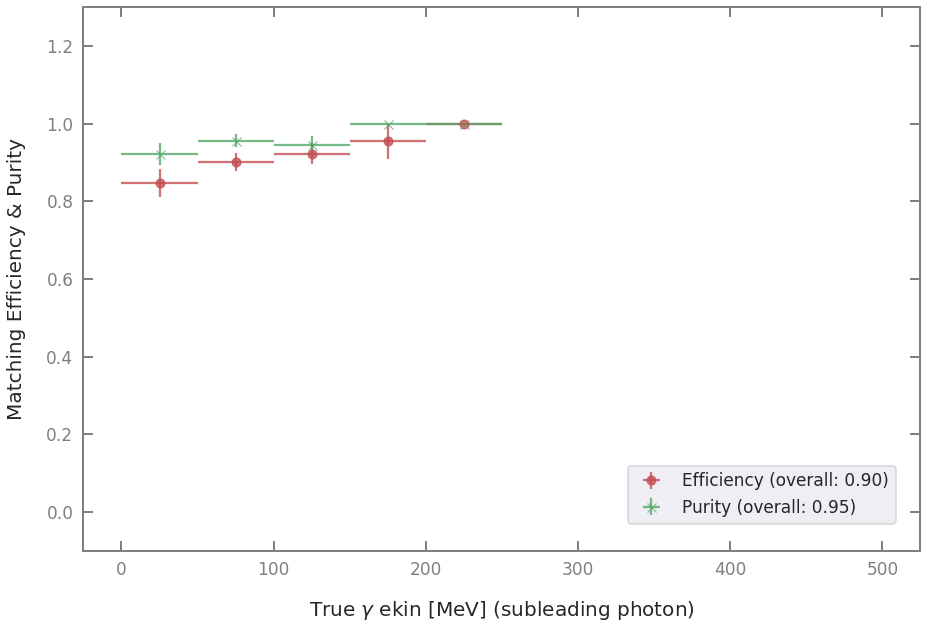

In [12]:
# Plot matching efficiencies and purities as a function of the true pi0 ekin
print(' x_bins:                         ', x_bins)
print(' x_list:                         ', x_list)
print(' x_err_list:                     ', x_err_list)
print(' matching_eff_subleading:        ', matching_eff_subleading)
print(' matching_eff_uncert_subleading: ', matching_eff_uncert_subleading)
print(' matching_pur_subleading:        ', matching_pur_subleading)
print(' matching_pur_uncert_subleading: ', matching_pur_uncert_subleading)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)


# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Plot
plt.errorbar(x_list, matching_eff_subleading, xerr=x_err_list, yerr=matching_eff_uncert_subleading, label='Efficiency (overall: %.2f)' %overall_eff_subleading, fmt='o', color='r', alpha=0.8)
plt.errorbar(x_list, matching_pur_subleading, xerr=x_err_list, yerr=matching_pur_uncert_subleading, label='Purity (overall: %.2f)' %overall_pur_subleading, fmt='x', color='g', alpha=0.8)
#n, bins, patches = plt.hist(matching_eff, bins=n_bins_x, range=[x_min,x_max], histtype='step', stacked=False, linewidth=3, alpha=0.8, color='red')

# Axis labels
plt.xlabel('True $\gamma$ ekin [MeV] (subleading photon)', fontsize=20, labelpad=20)
plt.ylabel('Matching Efficiency & Purity', fontsize=20, labelpad=20)

plt.ylim(bottom=-0.1, top=1.3)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)

#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')
#plt.axhline(overall_eff, color='r', linestyle='dashed', linewidth=2, label='Overall efficiency (%.2f)' %overall_eff)
#plt.axhline(overall_pur, color='g', linestyle='dashed', linewidth=2, label='Overall purity (%.2f)' %overall_pur)

# Legend
#entry_0 = 'Efficiency'
#entry_1 = 'Purity'
plt.legend(loc=[0.65,0.05], prop={'size': 17}) # loc='upper right'


# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'

# Get file name
#print(chain_cfg)
start_index = chain_cfg.find('data_keys:') + 10
end_index = chain_cfg.find('limit_num_files:')
words = chain_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/pi0/')
        file_name = words[i][start_index+9:]
        break
print(' file_name = ', file_name)
#file_name = 'pi0_dunend_v1_p00'

fig_name = 'matching_eff_pur_subleadingPhoton' +\
            str(data_size) + 'events_' +\
            'from_file_' + file_name + '_root.png'
#            'from_file_' + str(chain.chain_cfg['iotool']['dataset']['data_keys'])[13:-7] +'_root.png'
#          ' SELECTION_CUTS:
print(' fig_name: ', fig_name)
if True:
    plt.savefig('plots/' + fig_name, dpi=400) # bbox_inches='tight'

 x_bins:               [  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500.]
 x_list:               [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0]
 x_err_list:           [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
 matching_eff:         [0.8, 0.9074074074074074, 0.8780487804878049, 0.8909090909090909, 0.8591549295774648, 0.9482758620689655, 0.9423076923076923, 0.8541666666666666, -9, -9]
 matching_eff_uncert:  [0.17888543819998315, 0.03944504014954899, 0.05110465578801792, 0.04203679830482469, 0.041283584119470355, 0.029080373606172643, 0.03233356951833491, 0.05094236371917087, 0, 0]
 matching_pur:         [1.0, 0.9423076923076923, 0.9473684210526315, 0.9423076923076923, 0.8970588235294118, 1.0, 0.9607843137254902, 0.9534883720930233, -9, -9]
 matching_pur_uncert:  [0.0, 0.03233356951833491, 0.036223536926930824, 0.03233356951833491, 0.03685110954061097, 0.0, 0.02718052078759497, 0.03211472761342027, 0, 0]
 file_name =  pi0_dunend_v2_p00
 fig_n

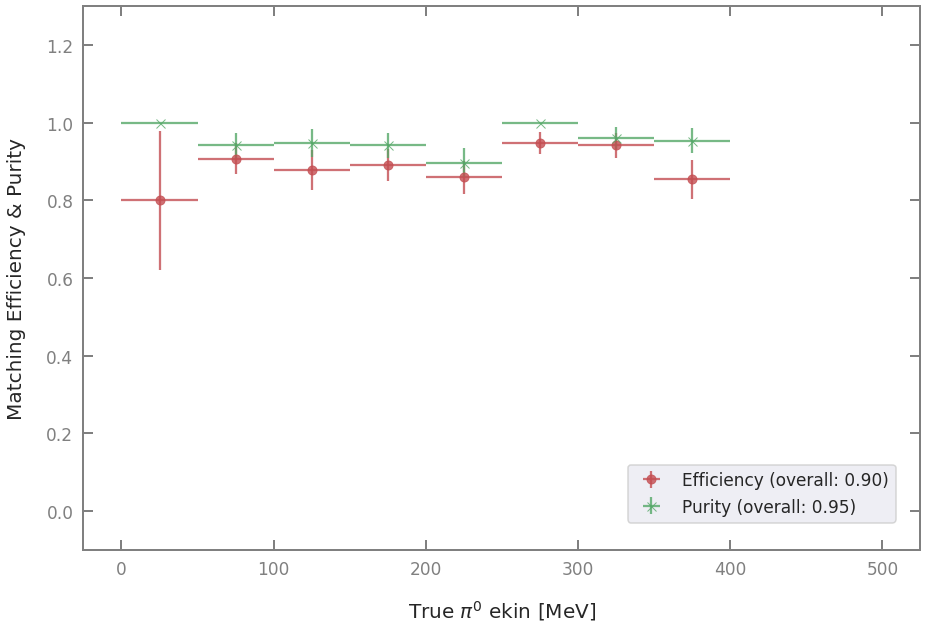

In [13]:
# Plot matching efficiencies and purities as a function of the true gamma subleading ekin
print(' x_bins:              ', x_bins)
print(' x_list:              ', x_list)
print(' x_err_list:          ', x_err_list)
print(' matching_eff:        ', matching_eff)
print(' matching_eff_uncert: ', matching_eff_uncert)
print(' matching_pur:        ', matching_pur)
print(' matching_pur_uncert: ', matching_pur_uncert)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)


# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Plot
plt.errorbar(x_list, matching_eff, xerr=x_err_list, yerr=matching_eff_uncert, label='Efficiency (overall: %.2f)' %overall_eff, fmt='o', color='r', alpha=0.8)
plt.errorbar(x_list, matching_pur, xerr=x_err_list, yerr=matching_pur_uncert, label='Purity (overall: %.2f)' %overall_pur, fmt='x', color='g', alpha=0.8)
#n, bins, patches = plt.hist(matching_eff, bins=n_bins_x, range=[x_min,x_max], histtype='step', stacked=False, linewidth=3, alpha=0.8, color='red')

# Axis labels
plt.xlabel('True $\pi^0$ ekin [MeV]', fontsize=20, labelpad=20)
plt.ylabel('Matching Efficiency & Purity', fontsize=20, labelpad=20)

plt.ylim(bottom=-0.1, top=1.3)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)

#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')
#plt.axhline(overall_eff, color='r', linestyle='dashed', linewidth=2, label='Overall efficiency (%.2f)' %overall_eff)
#plt.axhline(overall_pur, color='g', linestyle='dashed', linewidth=2, label='Overall purity (%.2f)' %overall_pur)

# Legend
#entry_0 = 'Efficiency'
#entry_1 = 'Purity'
plt.legend(loc=[0.65,0.05], prop={'size': 17}) # loc='upper right'


# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'

# Get file name
#print(chain_cfg)
start_index = chain_cfg.find('data_keys:') + 10
end_index = chain_cfg.find('limit_num_files:')
words = chain_cfg[start_index:end_index].split('.root')
for i in range(len(words)):
    #print(words[i])
    if words[i].find('#')>0:
        continue
    else:
        start_index = words[i].find('data/pi0/')
        file_name = words[i][start_index+9:]
        break
print(' file_name = ', file_name)
#file_name = 'pi0_dunend_v1_p00'

fig_name = 'matching_eff_pur_' +\
            str(data_size) + 'events_' +\
            'from_file_' + file_name + '_root.png'
#            'from_file_' + str(chain.chain_cfg['iotool']['dataset']['data_keys'])[13:-7] +'_root.png'
#          ' SELECTION_CUTS:
print(' fig_name: ', fig_name)
if True:
    plt.savefig('plots/' + fig_name, dpi=400) # bbox_inches='tight'

In [14]:
print(' correctly_matched: (',np.sum(correctly_matched), ') \t ', correctly_matched)
print(' wrongly_matched:   (',np.sum(wrongly_matched),   ') \t ', wrongly_matched)
print(' total_true_pi0:    (',np.sum(total_true_pi0),    ') \t ', total_true_pi0)
print(' total_reco_pi0:    (',np.sum(total_reco_pi0),    ') \t ', total_reco_pi0)

 correctly_matched: ( 344 ) 	  [4, 49, 36, 49, 61, 55, 49, 41, 0, 0]
 wrongly_matched:   ( 19 ) 	  [0, 3, 2, 3, 7, 0, 2, 2, 0, 0]
 total_true_pi0:    ( 384 ) 	  [5, 54, 41, 55, 71, 58, 52, 48, 0, 0]
 total_reco_pi0:    ( 363 ) 	  [4, 52, 38, 52, 68, 55, 51, 43, 0, 0]


 Fitted parameters: 
 a [-]: 	  966.8681970416031  
 μ [MeV/c2]: 	  130.5452595285677  
 σ [MeV/c2]: 	  10.744557068898976
 fig_name:  reconstructed_pi0_masses_1000events_from_file_pi0_dunend_v2_p00_root.png
Done.


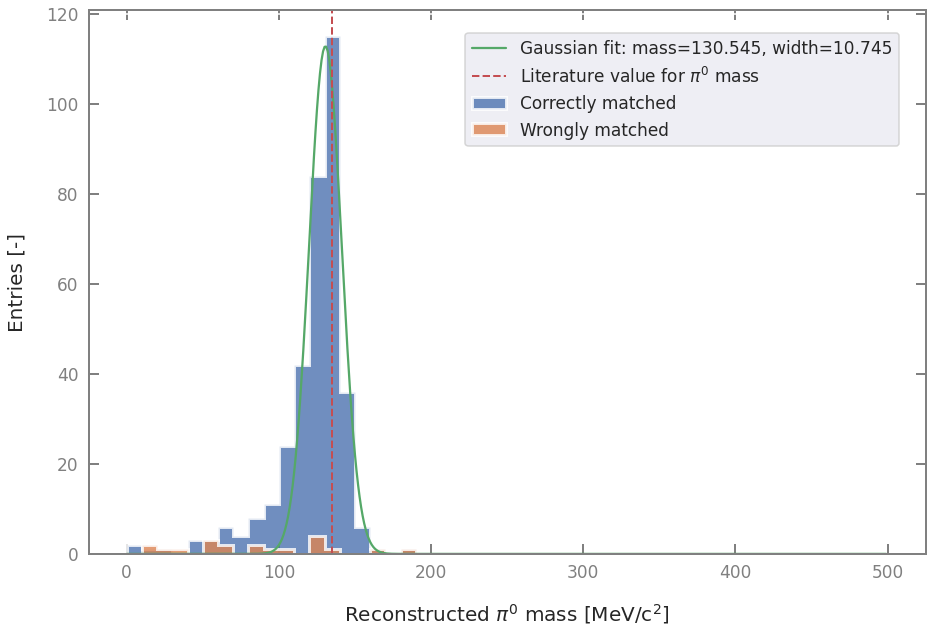

In [15]:
# Make plot with reconstructed pi0 masses
#print(' reco_pi0_mass_correctly_matched = ', reco_pi0_mass_correctly_matched)
#print(' reco_pi0_mass_wrongly_matched = ', reco_pi0_mass_wrongly_matched)

m_corr  = []
m_wrong = []
for i, entry in enumerate(reco_pi0_mass_correctly_matched):
    for j, mass in enumerate(entry):
        m_corr.append(mass)
for i, entry in enumerate(reco_pi0_mass_wrongly_matched):
    for j, mass in enumerate(entry):
        m_wrong.append(mass)

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma

def fit_func(bins, n, func, x_min, x_max):
    from scipy.optimize import curve_fit
    center = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(func, center, n, p0=(100, 100, 10))
    print(" Fitted parameters: \n a [-]: \t ", popt[0],
          " \n \u03BC [MeV/c2]: \t ", popt[1],
          " \n \u03C3 [MeV/c2]: \t ", popt[2])

    x = np.arange(x_min, x_max, 1)
    y = func(x, popt[0], popt[1], popt[2])
    plt.plot(x, y, label='Gaussian fit: mass=%5.3f, width=%5.3f' % (popt[1], popt[2]))
    plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')
    plt.legend(loc=[0.45,0.85], prop={'size': 17})
    #plt.legend([entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.6,0.7], prop={'size': 17}) # loc='upper right'
    #return popt[1], popt[2]

# Define histogram range and binning
x_min    = 0
x_max    = 500
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Plot masses
n_corr,  bins_corr,  patches_corr  = plt.hist(m_corr,  bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', label='Correctly matched', stacked=True, linewidth=3, alpha=0.8)
n_wrong, bins_wrong, patches_wrong = plt.hist(m_wrong, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', label='Wrongly matched', stacked=True, linewidth=3, alpha=0.8)

# Fit the peak with a Gaussian
fit_func(bins_corr, n_corr+n_wrong, gaus, x_min, x_max)
#mu, sigma = fit_func(bins, n, gaus, x_min, x_max)

# Plot legend
plt.legend(loc=[0.45,0.75], prop={'size': 17})

# Axis labels
plt.xlabel('Reconstructed $\pi^0$ mass [MeV/c$^2$]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=200)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)

#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Save figure
fig_name = 'reconstructed_pi0_masses_' +\
            str(data_size) + 'events_' +\
            'from_file_' + file_name + '_root.png'
#            'from_file_' + str(chain.chain_cfg['iotool']['dataset']['data_keys'])[13:-7] +'_root.png'
#          ' SELECTION_CUTS:
print(' fig_name: ', fig_name)
plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'
    
print('Done.')

 fig_name:  true_gamma_edep_correctly_matched_pi0s_1000events_from_file_pi0_dunend_v2_p00_root.png
Done.


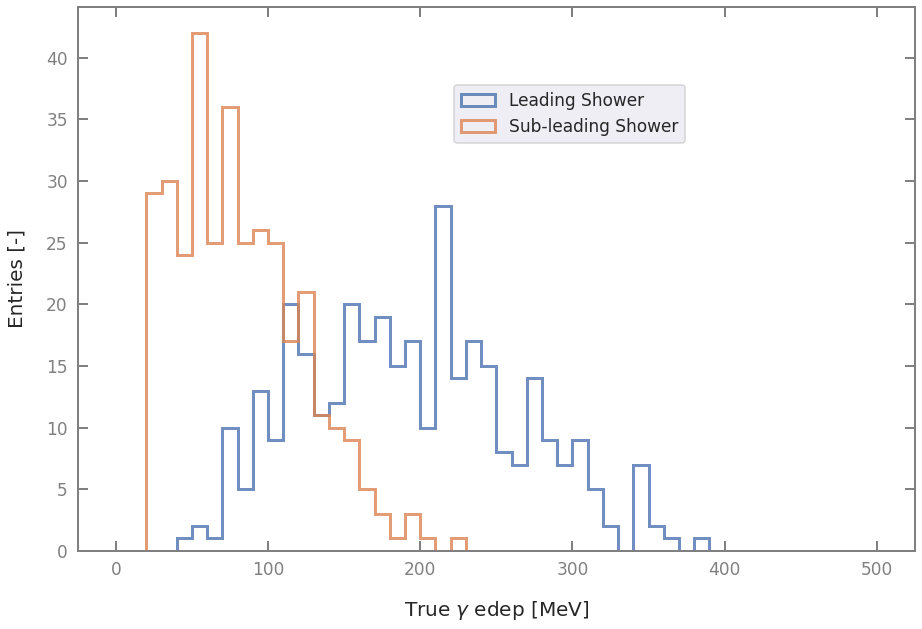

In [16]:
# Make plot with reconstructed pi0 masses
#print(' corr_match_true_gamma_edep_leading    = ', corr_match_true_gamma_edep_leading)
#print(' corr_match_true_gamma_edep_subleading = ', corr_match_true_gamma_edep_subleading)

import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 500
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Plot masses
n_corr,  bins_corr,  patches_corr  = plt.hist(corr_match_true_gamma_edep_leading,    bins=n_bins_x, range=[x_min,x_max], histtype='step', label='Leading Shower', stacked=True, linewidth=3, alpha=0.8)
n_wrong, bins_wrong, patches_wrong = plt.hist(corr_match_true_gamma_edep_subleading, bins=n_bins_x, range=[x_min,x_max], histtype='step', label='Sub-leading Shower', stacked=True, linewidth=3, alpha=0.8)

# Plot legend
plt.legend(loc=[0.45,0.75], prop={'size': 17})

# Axis labels
plt.xlabel('True $\gamma$ edep [MeV]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=200)

#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)

#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Save figure
fig_name = 'true_gamma_edep_correctly_matched_pi0s_' +\
            str(data_size) + 'events_' +\
            'from_file_' + file_name + '_root.png'
#            'from_file_' + str(chain.chain_cfg['iotool']['dataset']['data_keys'])[13:-7] +'_root.png'
#          ' SELECTION_CUTS:
print(' fig_name: ', fig_name)
plt.savefig('plots/'+fig_name, dpi=400) # bbox_inches='tight'
    
print('Done.')

In [17]:
stop here

# Make plots (e.g. photon energies, opening angle, etc. for events with no matched pi0)
- why is there no matched pi0?

SyntaxError: invalid syntax (<ipython-input-17-0626d8cc6fca>, line 1)

In [ ]:
event_ids_correctly_matched    = []
event_ids_wrongly_matched      = []
event_ids_no_reconstructed_pi0 = []

not_matched_list_smaller_true_gamma_edep = []
not_matched_list_larger_true_gamma_edep  = []
not_matched_list_smaller_reco_gamma_edep = []
not_matched_list_larger_reco_gamma_edep  = []

correctly_matched_list_smaller_true_gamma_edep = []
correctly_matched_list_larger_true_gamma_edep  = []
correctly_matched_list_smaller_reco_gamma_edep = []
correctly_matched_list_larger_reco_gamma_edep  = []

for event in eff_pur_list:
    
    if event.event_id in event_ids_wrongly_matched:
        if event.true_n_pi0s==1: # TODO: CHANGE IT FOR EVENTS WITH >1 PI0
            not_matched_list_smaller_true_gamma_edep.append(np.amin(event.true_gamma_edep))
            not_matched_list_larger_true_gamma_edep.append(np.amax(event.true_gamma_edep))
        if event.reco_n_pi0s==1: # TODO: CHANGE IT FOR EVENTS WITH >1 PI0
            not_matched_list_smaller_reco_gamma_edep.append(np.amin(event.reco_gamma_edep))
            not_matched_list_larger_reco_gamma_edep.append(np.amax(event.reco_gamma_edep))
            
    if event.event_id in event_ids_correctly_matched:
        if event.true_n_pi0s==1: # TODO: CHANGE IT FOR EVENTS WITH >1 PI0
            correctly_matched_list_smaller_true_gamma_edep.append(np.amin(event.true_gamma_edep))
            correctly_matched_list_larger_true_gamma_edep.append(np.amax(event.true_gamma_edep))
        if event.reco_n_pi0s==1: # TODO: CHANGE IT FOR EVENTS WITH >1 PI0
            correctly_matched_list_smaller_reco_gamma_edep.append(np.amin(event.reco_gamma_edep))
            correctly_matched_list_larger_reco_gamma_edep.append(np.amax(event.reco_gamma_edep))
        
        '''
        print(' ----------------------------------------------------------- ')
        print(' event_id:                  ', event.event_id)
        print(' true_n_pi0s:               ', event.true_n_pi0s)
        print(' reco_n_pi0s:               ', event.reco_n_pi0s)
        print(' true_pi0_ekin:             ', event.true_pi0_ekin)
        print(' true_gamma_mom:            ', event.true_gamma_mom)
        print(' true_gamma_edep:           ', event.true_gamma_edep)
        #print(' correctly_matched_n_pi0:   ', event.correctly_matched_n_pi0)
        print(' correctly_matched_pi0_ids: ', event.correctly_matched_pi0_ids)
        print(' wrongly_matched_pi0_ids:   ', event.wrongly_matched_pi0_ids)
        print(' reject_pi0:                ', event.reject_pi0)
        '''
        
#print(' \n not_matched_list_smaller_true_gamma_edep: ', not_matched_list_smaller_true_gamma_edep)
#print(' \n not_matched_list_larger_true_gamma_edep:  ', not_matched_list_larger_true_gamma_edep)
#print(' \n not_matched_list_smaller_reco_gamma_edep: ', not_matched_list_smaller_reco_gamma_edep)
#print(' \n not_matched_list_larger_reco_gamma_edep:  ', not_matched_list_larger_reco_gamma_edep)

print('Done')

In [ ]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 500
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Plot n_edeps
#n0, bins0, patches0 = plt.hist([not_matched_list_smaller_true_gamma_edep], label='not matched smaller true',  bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
#n1, bins1, patches1 = plt.hist([not_matched_list_larger_true_gamma_edep],  label='not matched larger true',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
n2, bins2, patches2 = plt.hist([not_matched_list_smaller_reco_gamma_edep], label='not matched smaller reco',  bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=5, alpha=0.5)
n3, bins3, patches3 = plt.hist([not_matched_list_larger_reco_gamma_edep],  label='not matched larger reco',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=5, alpha=0.5)

#n4, bins4, patches4 = plt.hist([correctly_matched_list_smaller_true_gamma_edep], label='correctly matched smaller true',  bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
#n5, bins5, patches5 = plt.hist([correctly_matched_list_larger_true_gamma_edep],  label='correctly matched larger true',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
n6, bins6, patches6 = plt.hist([correctly_matched_list_smaller_reco_gamma_edep], label='correctly matched smaller reco',  bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=5, alpha=0.5)
n7, bins7, patches7 = plt.hist([correctly_matched_list_larger_reco_gamma_edep],  label='correctly matched larger reco',   bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=5, alpha=0.5)

# Legend
plt.legend(loc=[0.55,0.7], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('True & reco shower deposited energy [MeV]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=200)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
#fig_name = 'pi0_mass_02_' +\
#            str(data_size) + 'ev_' +\
#            'refit_dir_' + str(chain.cfg['refit_dir']) + '_' +\
#            'fiducial_0px_' +\
#            'no_selection_cut.png'
#plt.savefig('plots/' + fig_name, dpi=400) # bbox_inches='tight'